# Определение неэффективных операторов

Клиенты провайдера виртуальной телефонии — колл-центры, которые распределяют входящие вызовы на операторов и совершают исходящие вызовы силами операторов. Также операторы могут делать внутренние вызовы — вызовы друг между другом внутри сети виртуальной телефонии.

Провайдеру необходимо помочь определить неэффективных операторов. Признаки низкой эффективности оператора:
- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

Заказчиком исследования является продуктовый менеджер из отдела продуктовой разработки провадера. В дальнейшем на основе исследования будет разработан алгоритм для встраивания в сервис как отдельный функционал. Выявление неэффективных сотрудников позволит в будущем увеличить ценность сервиса для клиента, а значит потенциально увеличит время жизни клиента.


**Ход исследования:**

Данные со статистикой использования услуг провайдера и описание клиентов мы получим из файлов `telecom_dataset.csv` и `telecom_clients.csv`, соответтсвенно 

О качестве данных ничего не известно. Поэтому перед проведением исследовательского анализа нам понадобится сделать их обзор. Мы проверим данные на ошибки и затем на этапе предобработки мз исправим.

**Этапы исследования:**
1. Загрузка и изучение данных.
2. Предобработка данных.
3. Расчеты и добавление метрик, необходимых для исследования.
4. Исследовательский анализ данных.
5. Решение основных вопросов заказчика.
6. Проверка статистических гипотез.
7. Общий вывод и рекомендации для заказчика.
8. Презентация результатов исследования.

## Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# функция для первичного анализа датасета
def primary_analysis (data):
    display(data.head(5))
    display(data.info())
    display(data.describe())
    print('\nКоличество уникальных значений в столбцах:')
    print(data.nunique())
    print("\nКоличество явных дубликатов: {}, что составляет {:,.1%} от общего объема.".format(data.duplicated().sum(), data.duplicated().mean()))

### Информация об использовании услуг

In [3]:
data = pd.read_csv('telecom_dataset.csv')
primary_analysis(data)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000



Количество уникальных значений в столбцах:
user_id                 307
date                    119
direction                 2
internal                  2
operator_id            1092
is_missed_call            2
calls_count             502
call_duration          5373
total_call_duration    6040
dtype: int64

Количество явных дубликатов: 4900, что составляет 9.1% от общего объема.


Описание столбцов в `telecom_clients.csv` согласно документации:
* `user_id` — идентификатор клиентского аккаунта в сервисе;
* `date` — дата статистики;
* `direction` — направление вызовов (out - исходящий вызов, in — входящий вызов);
* `internal` — является ли звонок внутренним звонком между операторами клиента;
* `operator_id` — идентификатор оператора;
* `is_missed_call` — является ли звонок пропущенным;
* `calls_count` — количество звонков;
* `call_duration` — длительность звонка (без учета времени ожидания) в минутах;
* `total_call_duration` — длительность звонка (с учетом времени ожидания) в минутах.

В каждой строке таблицы представлены данные о звонках операторов. 
В столбцах `date`, `operator_id` и `internal` тип данных  не соответствует документации и имеются пропуски. Также в датасете есть явные дубликаты.

### Информация о клиентах

In [4]:
clients = pd.read_csv('telecom_clients.csv')
primary_analysis(clients)
clients['tariff_plan'].unique()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000



Количество уникальных значений в столбцах:
user_id        732
tariff_plan      3
date_start      73
dtype: int64

Количество явных дубликатов: 0, что составляет 0.0% от общего объема.


array(['A', 'C', 'B'], dtype=object)

Описание столбцов `telecom_clients.csv` согласно документации:
* `user_id` — идентификатор клиентского аккаунта в сервисе;
* `tariff_plan` — текущий тарифный план клиента;
* `date_start` — дата регистрации клиентв в сервисе.

В каждой строке таблицы — данные о клиентах. В датасете нет пропусков, тип данных в `date_start` не соответствует документации. Кроме того, в данных содержится информация о 732 уникальных клиентах, в то время как в датасете `data` их всего 307.

### Вывод:
Предварительно можно утверждать, что данных достаточно для проведения исследования. Но в данных есть пропуски и дубликаты, которые необходимо обработать перед проведением исследования.

## Предобработка данных

### Пропущенные значения
Проанализируем и обработаем пропуски в столбцах `operator_id`: 

In [5]:
df = data[data['operator_id'].isna()]
print('\nСтолбец', df.groupby('internal').size() / len(df))
print('\nСтолбец', df.groupby('direction').size() / len(df))
print('\nСтолбец', df.groupby('is_missed_call').size() / len(df))


Столбец internal
False    0.949584
True     0.043441
dtype: float64

Столбец direction
in     0.975526
out    0.024474
dtype: float64

Столбец is_missed_call
False    0.014929
True     0.985071
dtype: float64


Свыше 95% записей с пропусками в столбце `operator_id` является пропущенными внешними входящими звонками. 
Вероятнтее всего, пропуски связаны с особенностью обработки входящих звонков платформой: пока звонки находятся в очереди ожидания ответа и не распределены, оператор неизвестен. Аналогичным образом платформа работает и для внутренних звонков. Учтем эту особенность при последующем анализе данных. Заполним пропуски в стобце `operator_id`:

In [6]:
# для пропущенных звонков, которые находились в очереди ожидания, заполним пропуски в 'operator_id' заглушкой -1
data['operator_id'] = data['operator_id'].fillna(-1) 

Проанализируем оставшую часть записей с пропусками в стобце `operator_id`, где были исходящие звонки и непропущенные звонки:  

In [7]:
display(df.query('direction=="out"').head(5))
print("{:,.3%}".format(len(df.query('direction=="out"'))/len(data)))

display(df.query('is_missed_call==False').head(5))
print("{:,.3%}".format(len(df.query('is_missed_call==False'))/len(data)))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
455,166377,2019-11-06 00:00:00+03:00,out,False,NaN,True,1,0,1
2402,166407,2019-10-10 00:00:00+03:00,out,True,NaN,True,1,0,0
3241,166485,2019-10-15 00:00:00+03:00,out,True,NaN,True,2,0,8
3271,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11
3276,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11


0.371%


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220
4136,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397


0.226%


Природа подобных данных не ясна; мы не сможем их использовать для дальнейшго анализа эффективности операторов. 
Поскольку доля подобных записей мала, отбросим их:

In [8]:
data = data.query('operator_id!=-1 | is_missed_call==True')
data = data.query('operator_id!=-1 | direction=="in"')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53629 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53629 non-null  int64  
 1   date                 53629 non-null  object 
 2   direction            53629 non-null  object 
 3   internal             53514 non-null  object 
 4   operator_id          53629 non-null  float64
 5   is_missed_call       53629 non-null  bool   
 6   calls_count          53629 non-null  int64  
 7   call_duration        53629 non-null  int64  
 8   total_call_duration  53629 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


Пропуски в столбце `internal` пока оставим без изменений.

### Изменение типов данных
Изменим типы данных в столбцах, чтобы они соответствовали предоставленной документации, и заодно оптимизируем размер датасета:

In [9]:
data['date'] = pd.to_datetime(data['date']).dt.date
data['operator_id'] = data['operator_id'].astype('int32')
data['user_id'] = data['user_id'].astype('int32')
data['calls_count'] = data['calls_count'].astype('int16')
data['call_duration'] = data['call_duration'].astype('int32')
data['total_call_duration'] = data['total_call_duration'].astype('int32')
data['internal'] = data['internal'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53629 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              53629 non-null  int32 
 1   date                 53629 non-null  object
 2   direction            53629 non-null  object
 3   internal             53629 non-null  bool  
 4   operator_id          53629 non-null  int32 
 5   is_missed_call       53629 non-null  bool  
 6   calls_count          53629 non-null  int16 
 7   call_duration        53629 non-null  int32 
 8   total_call_duration  53629 non-null  int32 
dtypes: bool(2), int16(1), int32(4), object(2)
memory usage: 2.3+ MB


### Обработка дубликатов

In [10]:
#обработаем явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48748 entries, 0 to 48747
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              48748 non-null  int32 
 1   date                 48748 non-null  object
 2   direction            48748 non-null  object
 3   internal             48748 non-null  bool  
 4   operator_id          48748 non-null  int32 
 5   is_missed_call       48748 non-null  bool  
 6   calls_count          48748 non-null  int16 
 7   call_duration        48748 non-null  int32 
 8   total_call_duration  48748 non-null  int32 
dtypes: bool(2), int16(1), int32(4), object(2)
memory usage: 1.7+ MB


### Ошибки в данных

Теперь исследуем данные на наличие ошибок и аномалий: 

In [11]:
display(data.describe())

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,48748.000000,48748.000000,48748.000000,48748.000000,48748.000000
mean,167293.149093,781116.568064,16.524616,860.586486,1152.196747
std,597.674210,325814.186153,63.760732,3768.964082,4449.194581
min,166377.000000,-1.000000,1.000000,0.000000,0.000000
25%,166782.000000,890422.000000,1.000000,0.000000,47.000000
50%,167158.000000,906408.000000,4.000000,37.000000,210.000000
75%,167816.000000,930020.000000,12.000000,570.000000,901.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


В данных имеются недопустимые значения:
* Максимальное значение столбца `calls_count` составляет 4817 звонков: в реальности совершить такое количество звонков за день невозможно;
* В документации к данным указано, что длительность звонков в столбцах `call_duration` и `total_call_duration` указана в минутах: характерные значения столбцов указывают на то, что длительность звонков посчитана в секундах;
* После приведения единиц измерения максимальное значение длительности звонков за день в `call_duration` и `total_call_duration` составляет 40 и 46 часов, соответственно, что невозможно. 

Определим 90, 95 и 99 перцентиль значений каждого проблемного столбца:

In [12]:
col_names = ['calls_count', 'call_duration', 'total_call_duration']
for col in col_names:
    print(col)
    print(np.percentile(data[col], [90, 95, 99]))

calls_count
[ 35.  62. 166.]
call_duration
[ 2082.    3700.65 10202.83]
total_call_duration
[ 2602.3   4502.   12809.59]


Не более 5% записей датасета имеют больше 62 звонков, длительность дольше 3700.65 сек (без учета ожидания) и 4502 сек (с учетом ожидания). Примем эти значения в качестве верхних границ для значений столбцов. Проблемные данные сохраним в отдельный датасет и сообщим о них администратору БД:

In [13]:
problematic_data = data.query('calls_count>62 & call_duration>3700 & total_call_duration>4502')
data = data.query('calls_count<=62 & call_duration<=3700 & total_call_duration<=4502')
display(data.describe())

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,45005.000000,45005.000000,45005.000000,45005.000000,45005.000000
mean,167274.613932,773733.185979,7.821198,383.748272,520.398156
std,587.599165,332545.818274,10.764663,704.309921,788.795392
min,166377.000000,-1.000000,1.000000,0.000000,0.000000
25%,166782.000000,890416.000000,1.000000,0.000000,41.000000
50%,167150.000000,906400.000000,3.000000,27.000000,168.000000
75%,167756.000000,929424.000000,9.000000,429.000000,635.000000
max,168606.000000,973286.000000,62.000000,3700.000000,4488.000000


Проанализируем подробнее столбец `call_duration` для записей с пропущенными выовами:

In [14]:
display(data.query('is_missed_call==True & call_duration>0').head(5))
print("{:,.3%}".format(len(data.query('is_missed_call==True & call_duration>0'))/len(data)))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1468,166405,2019-11-19,in,False,939478,True,1,165,173
1495,166405,2019-11-21,in,False,882686,True,1,1,5
1515,166405,2019-11-22,in,False,882686,True,1,1,5
2086,166407,2019-09-23,in,False,888534,True,1,133,156
2621,166482,2019-11-05,in,False,934074,True,1,1,15


0.658%


Если звонок является пропущенным, то длительность разговора должна быть равна 0. Природа подобных записей непонятна. 
Поскольку доля подобных записей мала, отбросим их: 

In [15]:
data = data.query('is_missed_call==False | call_duration==0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44709 entries, 0 to 48747
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              44709 non-null  int32 
 1   date                 44709 non-null  object
 2   direction            44709 non-null  object
 3   internal             44709 non-null  bool  
 4   operator_id          44709 non-null  int32 
 5   is_missed_call       44709 non-null  bool  
 6   calls_count          44709 non-null  int16 
 7   call_duration        44709 non-null  int32 
 8   total_call_duration  44709 non-null  int32 
dtypes: bool(2), int16(1), int32(4), object(2)
memory usage: 1.9+ MB


### Вывод:  
Данные готовы для проведения исследовательского анализа.

## Расчеты и добавление метрик, необходимых для исследования

### Длительность периода

Рассчитаем даты начала и конца периода для выборки, а также его длительность:

In [16]:
print('Дата начала периода:', data['date'].min())
print('Дата окончания периода:', data['date'].max())
c_days = (data['date'].max() - data['date'].min()).days
print('Итого дней:', c_days)

Дата начала периода: 2019-08-02
Дата окончания периода: 2019-11-28
Итого дней: 118


### Анализ статистических данных

Проанализируем распределение ежедневного количества звонков, длительности звонка с учетом и без учета ожидания:

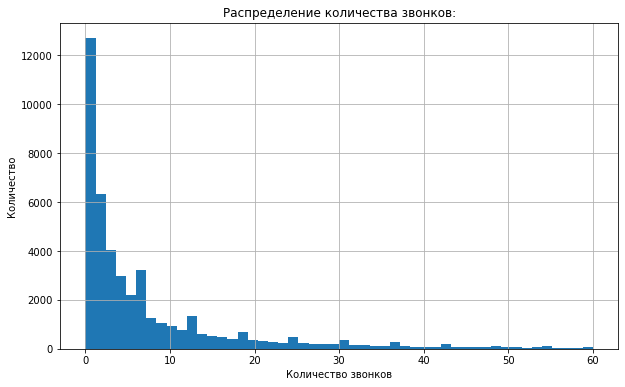

In [17]:
plt.title('Распределение количества звонков:')
plt.xlabel('Количество звонков')
plt.ylabel('Количество')
data['calls_count'].hist(bins=50, range = (0, 60), figsize=(10,6))
plt.show();

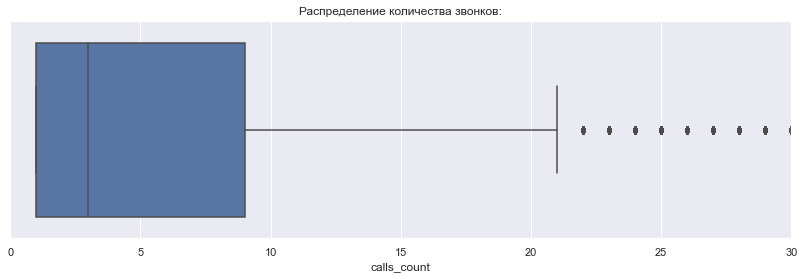

In [18]:
sns.set(rc={'figure.figsize':(14,4)})
plt.title('Распределение количества звонков:')
sns.boxplot(data=data, x='calls_count').set(xlim=(0, 30))
plt.show();

**Выврд:** нормальные значения количества вызовов распределены в диапазоне от 0 до 21, значения за пределами диапазона являются выбросами.

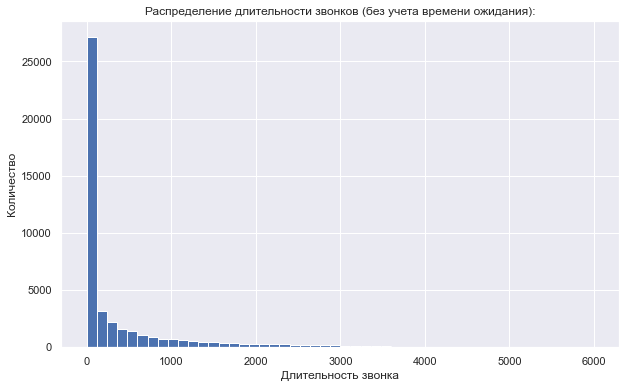

In [19]:
plt.title('Распределение длительности звонков (без учета времени ожидания):')
plt.xlabel('Длительность звонка')
plt.ylabel('Количество')
data['call_duration'].hist(bins=50, range = (0, 6000), figsize=(10,6))
plt.show();

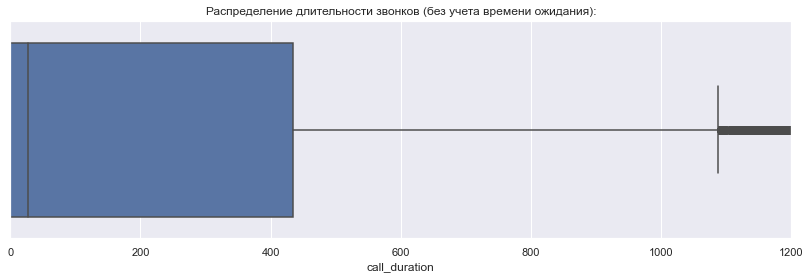

In [20]:
sns.set(rc={'figure.figsize':(14,4)})
plt.title('Распределение длительности звонков (без учета времени ожидания):')
sns.boxplot(data=data, x='call_duration').set(xlim=(0, 1200))
plt.show();

**Вывод:** нормальные значения длительности звонков (без учета времени ожидания) распределены в диапазоне от 0 до 1140 сек, значения за пределами диапазона являются выбросами.

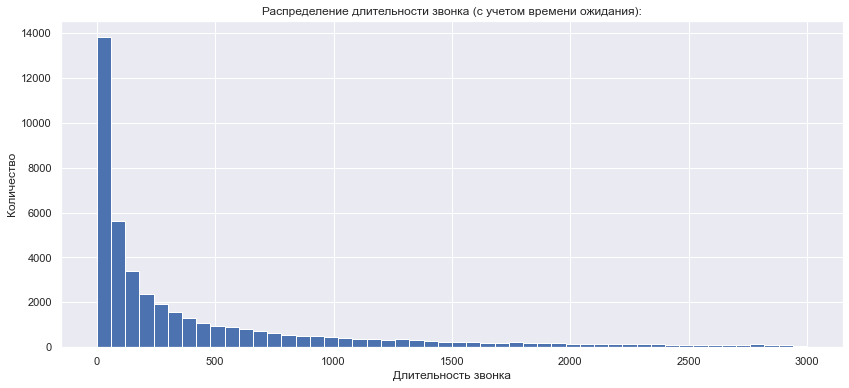

In [21]:
plt.title('Распределение длительности звонка (с учетом времени ожидания):')
plt.xlabel('Длительность звонка')
plt.ylabel('Количество')
data['total_call_duration'].hist(bins=50, range = (0, 3000), figsize=(14,6))
plt.show();

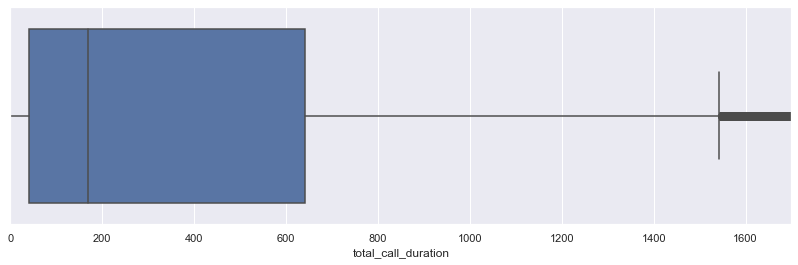

In [22]:
sns.set(rc={'figure.figsize':(14,4)})
sns.boxplot(data=data, x='total_call_duration').set(xlim=(0, 1700))
plt.show();

**Вывод:** нормальные значения длительности звонков (с учетом времени ожидания) распределены в диапазоне от 0 до 1550 сек, значения за пределами диапазона являются выбросами.

Проанализируем распределение клиентов по тарифным планам:

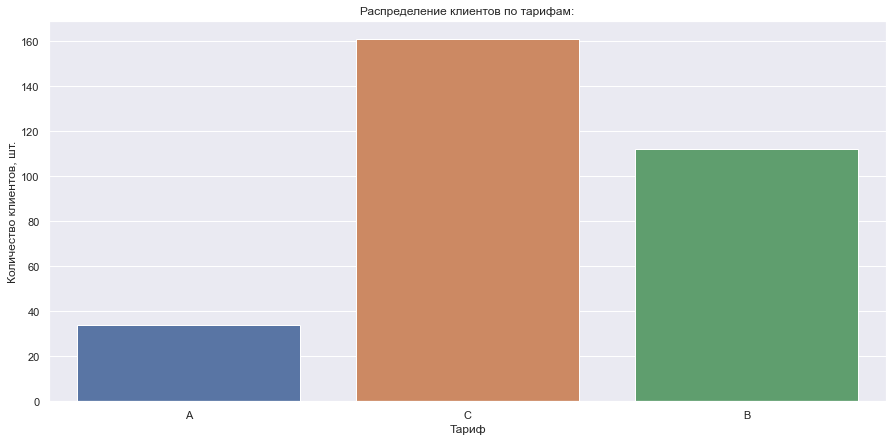

In [23]:
# список уникальных user_id из датасета data
unique_user_id = data.user_id.unique()

sns.set(rc={'figure.figsize':(15,7)})
fig, ax = plt.subplots()
ax.set_title('Распределение клиентов по тарифам:')
ax = sns.countplot(x='tariff_plan', data=clients.query('user_id in @unique_user_id'))
ax.set_xlabel('Тариф')
ax.set_ylabel('Количество клиентов, шт.')
plt.show();

**Вывод:** наибольшее количество клиентов использует тариф C, меньше всего абонентов у тарифа А.

### Классификация звонков

Для каждой записи датасета классифиципуем тип звонка: `ad` - если звонок был исходящим внешним, `hotline` - для всех остальных

In [24]:
# функция call_type опредеяет тип звонка
def call_type(data):
    if data['direction'] == 'out' and data['internal']==False:
        return 'ad'
    else:
        return 'hotline'

data['call_type'] = data.apply(call_type, axis=1)
display(data.head(5))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_type
0,166377,2019-08-04,in,False,-1,True,2,0,4,hotline
1,166377,2019-08-05,out,True,880022,True,3,0,5,hotline
2,166377,2019-08-05,out,True,880020,True,1,0,1,hotline
3,166377,2019-08-05,out,True,880020,False,1,10,18,hotline
4,166377,2019-08-05,out,False,880022,True,3,0,25,ad


### Классификация клиентов

Классифицируем клиентов по двум типам:
* Call-центры, которые распределяют входящие вызовы по своим операторам (1-ый тип): если у CALL-центра преобладают звонки с типом `hotline`;
* Call-центры, которые обеспечивают исходящие вызовы от своих операторов (2-ой тип): если у CALL-центра преобладают звонки с типом `ad`.

In [25]:
# сводная таблица с операторами, а также количеством и долей звонков каждого типа 
stat = data.pivot_table(index=['user_id'], columns=['call_type'], values=['calls_count'], aggfunc=['sum'], fill_value=0).reset_index()
stat.columns = ['user_id','hotline', 'ads']
stat['hotline_share'] = stat['hotline'] / (stat['hotline'] + stat ['ads'])
stat['ad_share'] = 1-stat['hotline_share']
stat.reset_index(drop=True)

# функция client_type классифицирует клиентов в зависимости от того, какая доля звонков преобладает
def client_type(data):
    if data['ad_share'] > data['hotline_share']:
        return 2
    else:
        return 1
    
stat['client_type'] = stat.apply(client_type, axis=1)

# функция classify_type записывает тип клиента в датасет data
def classify_type(data):
    tmp = stat.query('user_id==@data.user_id').reset_index(drop=True)
    return tmp.client_type[0]

data['client_type'] = data.apply(classify_type, axis=1)
display(data.head(5))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_type,client_type
0,166377,2019-08-04,in,False,-1,True,2,0,4,hotline,1
1,166377,2019-08-05,out,True,880022,True,3,0,5,hotline,1
2,166377,2019-08-05,out,True,880020,True,1,0,1,hotline,1
3,166377,2019-08-05,out,True,880020,False,1,10,18,hotline,1
4,166377,2019-08-05,out,False,880022,True,3,0,25,ad,1


### Распределение клиентов по типу

Изучим распределение клиентов в зависимости от их типа:

client_type
1    128
2    179
dtype: int64


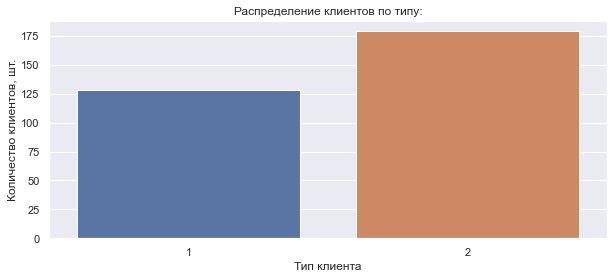

In [26]:
print(stat.groupby('client_type').size())

sns.set(rc={'figure.figsize':(10,4)})
fig, ax = plt.subplots()
#sns.set_style('ticks')
sns.set_style('whitegrid')
ax.set_title('Распределение клиентов по типу:')
ax = sns.countplot(x='client_type', data=stat)
ax.set_xlabel('Тип клиента')
ax.set_ylabel('Количество клиентов, шт.')
plt.show();

**Вывод:** у провайдера 129 клиентов 1-го типа и 179 клиентов 2-го типа.

###  ТОП-5 клиентов по количеству операторов

Определим ТОП-5 клиентов каждого типа по количеству операторов:


ТОП-5 клиентов 1-го типа:


,index,user_id,total_operators
0,113,168187,51
1,77,167626,49
2,71,167497,31
3,116,168252,29
4,121,168361,28


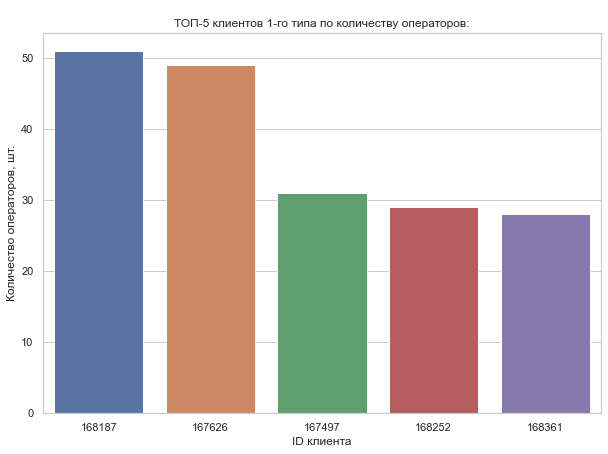


ТОП-5 клиентов 2-го типа:


,index,user_id,total_operators
0,37,166916,17
1,66,167176,16
2,91,167521,13
3,86,167445,12
4,142,168073,12


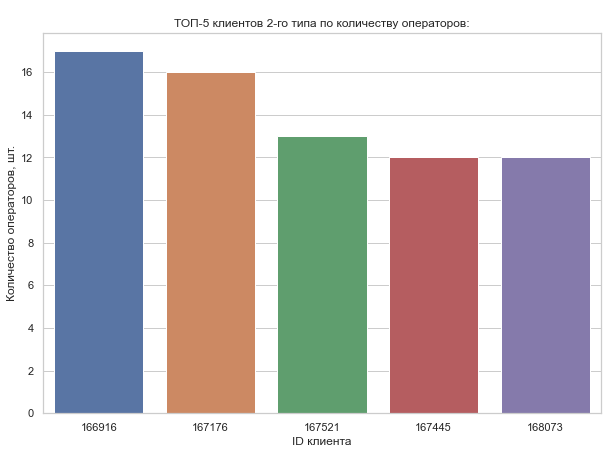

In [27]:
types = data['client_type'].unique()

for t in types:
    tmp = data.query('client_type==@t').pivot_table(index=['user_id'], values=['operator_id'], aggfunc=['nunique']).reset_index()
    tmp.columns = ['user_id', 'total_operators']
    tmp = tmp.sort_values(by='total_operators', ascending=False).reset_index().head(5)
    print("\nТОП-5 клиентов {}-го типа:".format(t))
    display(tmp)
     
    sns.set(rc={'figure.figsize':(10, 7)})
    sns.set_style('whitegrid')
    sns.barplot(x='user_id', y='total_operators', data=tmp, order=tmp.sort_values('total_operators', ascending=False).user_id)
    plt.ylabel('Количество операторов, шт.')
    plt.xlabel('ID клиента')
    plt.title("\nТОП-5 клиентов {}-го типа по количеству операторов:".format(t))
    plt.show();

**Вывод:** 
* Идентификаторы ТОП-5 клиентов 1-го типа по количеству операторов: 168187, 167626, 167497, 168252, 168361;
* Идентификаторы ТОП-5 клиентов 2-го типа по количеству операторов: 166916, 167176, 167521, 167445, 168073.

### Расчет метрик  для операторов

В зависимости от типа клиента рассчитаем для каждого оператора соответствующие метрики за период:
* Для клиентов 1-го типа:
    * общее количество входящих звонков;
    * общее количество пропущенных входящих звонков;
    * среднее время ожидания пропущенных входящих звонков;
    * общая длительность исходящих звонков;
* Для клиентов 2-го типа:
    * общее количество исходящих звонков;

In [28]:
# сводная таблица по клиентам 1-го типа с информацией об операторах и статистикой входящих звонков
incoming_calls = data.query('direction=="in" & client_type==1').pivot_table(
    index=['user_id', 'operator_id'],
    columns=['is_missed_call'],
    values=['calls_count'], 
    aggfunc={"calls_count": sum},
    fill_value=0
).reset_index()
incoming_calls.columns = ['user_id', 'operator_id', 'not_missed_calls', 'missed_calls']
incoming_calls['total_calls'] = incoming_calls['missed_calls'] + incoming_calls['not_missed_calls']

display(incoming_calls.head(5))

,user_id,operator_id,not_missed_calls,missed_calls,total_calls
0,166377,-1,0,94,94
1,166377,880020,7,0,7
2,166377,880022,8,0,8
3,166377,880026,24,0,24
4,166377,880028,63,0,63


In [29]:
# добавим в датасет data столбец со временем ожидания для звонков 
data['waiting_time'] = (data['total_call_duration'] - data['call_duration']) / data['calls_count'] 
#display(data.head(5))

# сводная таблица по клиентам 1-го типа с информацией об операторах и средним временем ожидания пропущенных входящих звонков
mc_waiting_time = data.query('direction=="in" & is_missed_call==True & client_type==1').pivot_table(
    index=['user_id','operator_id'],
    values=['waiting_time'], 
    aggfunc=['mean'],
    fill_value=0
).reset_index()
mc_waiting_time.columns = ['user_id','operator_id', 'mean_wt']
display(mc_waiting_time.head(5))

,user_id,operator_id,mean_wt
0,166377,-1,18.212798
1,166405,-1,17.749833
2,166405,882684,16.500000
3,166405,882686,12.666667
4,166405,882690,60.000000


In [30]:
# сводная таблица по клиентам 2-го типа с информацией об операторах, общим количеством исходящих звонков, отбратоннах дней и продолжительностью звонков 
outgoing_calls = data.query('direction=="out" & call_type=="ad" & client_type==2').pivot_table(
    index=['user_id','operator_id'],
    values=['date', 'calls_count','total_call_duration'], 
    aggfunc={'date': pd.Series.nunique, 'calls_count': np.sum,'total_call_duration': np.sum},
).reset_index()
#display(outgoing_calls.sort_values(by='date', ascending=False).head(10))
outgoing_calls.columns = ['user_id','operator_id', 'total_calls', 'total_days', 'total_calls_duration']

display(outgoing_calls.head(5))

,user_id,operator_id,total_calls,total_days,total_calls_duration
0,166407,888532,2,2,25
1,166407,888534,128,36,9541
2,166407,888536,1,1,114
3,166407,888538,2,2,395
4,166407,888540,1,1,222


### Вывод:

Данные, необходимые для проведения исследовательского анализа, подготовлены.

## Исследовательский анализ данных

Для клиентов 1-го типа определим пороги показателей эффективности CAR ("call abandonment rate" - показатель необработанных звонков) и ASA ("average speed of answer" - среднее время ответа); для клиентов 2-го типа найдем норматив по ежедневному количеству звонков.

### Порог показателя эффективности CAR

Расссчитаем CAR- порог эффективноси общей доли пропущенных звонков, которую не следует превышать. 
Найдем для каждого CALL-центра 1-го типа отношение количества пропущенных входящих звонков к общему количеству входящих звонков:

,user_id,missed_calls,total_calls,user_car
11,166619,1,3,0.333333
71,167626,16,141,0.113475
17,166688,1,9,0.111111
107,168253,8,72,0.111111
38,167002,1,17,0.058824


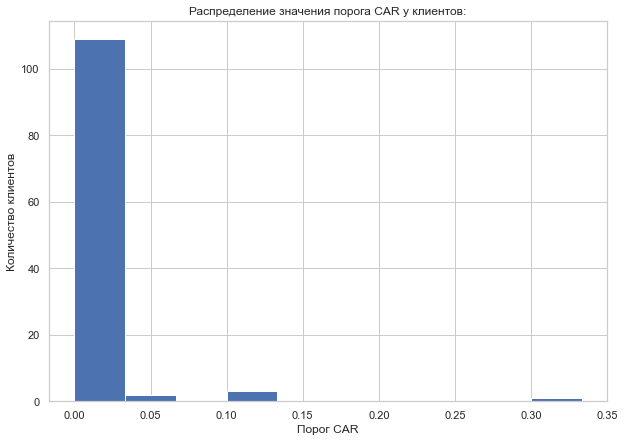

In [31]:
# при оасчете не будем учитывать пропущенные входящие звонки, которые находились в очереди ожидания
CAR = incoming_calls.query('operator_id!=-1').pivot_table(index=['user_id'], values=['missed_calls', 'total_calls'], aggfunc='sum').reset_index()
CAR['user_car'] = CAR['missed_calls'] / CAR ['total_calls']
display(CAR.sort_values(by='user_car').sort_values(by='user_car', ascending=False).head(5))

plt.title('Распределение значения порога CAR у клиентов:')
plt.xlabel('Порог CAR')
plt.ylabel('Количество клиентов')
plt.hist(CAR['user_car'])
plt.show();

**Вывод:** у большинства клиентов значение порога CAR близко к 0.

### Порог показателя эффективности ASA

Для расчета порога ASA нам нужно определить, сколько времени клиент, который звонит на горячую линию, готов ждать и когда бросает трубку? Для этого найдем среднее время ожидания пропущенных входящих звонков для операторов из выборки: 

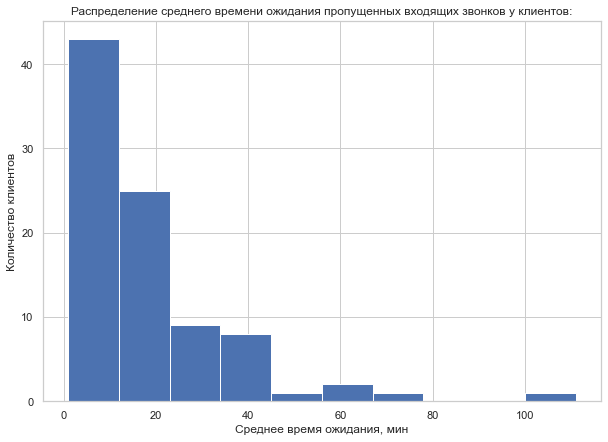

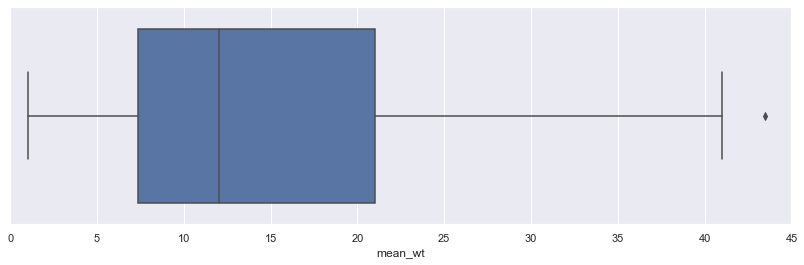

In [32]:
# при оасчете не будем учитывать пропущенные входящие звонки, которые находились в очереди ожидания
sns.set_style('whitegrid')
plt.title('Распределение среднего времени ожидания пропущенных входящих звонков у клиентов:')
plt.xlabel('Среднее время ожидания, мин')
plt.ylabel('Количество клиентов')
plt.hist(mc_waiting_time.query('operator_id!=-1')['mean_wt'])
plt.show();

sns.set(rc={'figure.figsize':(14,4)})
sns.boxplot(data=mc_waiting_time.query('operator_id!=-1'), x='mean_wt').set(xlim=(0, 45))
plt.show();

Найдем значения 1-го, 2-го и 3-го квартиля для `mean_wt`:

In [33]:
print(np.percentile(mc_waiting_time.query('operator_id!=-1')['mean_wt'], [25, 50, 75]))   
asa = np.percentile(mc_waiting_time.query('operator_id!=-1')['mean_wt'], 50)

[ 7.375 12.    21.   ]


**Вывод:** в качестве порога времени ожидания возьмем значение медианы, равное 12 мин.

### Норматив по ежедневному количеству звонков

Для расчета норматива по ежедневному количеству звонов сначала найдем AHT ("average handling time" - среднее время обработки звонка) для выборки, как отношение общей длительности исходящих звонков к общему количеству звонков. При расчете также следует учесть т.н. "период бездействия", в течение которого оператор завершает обработку предыдущего звонка и готовится к следующему. Возьмем период бездействия, равный 18% рабочего времени оператора:

In [34]:
idle_period = 0.18 # коэффицент периода бездействия
aht = outgoing_calls['total_calls_duration'].sum() / outgoing_calls['total_calls'].sum() * (1 + idle_period)
print("AHT={:,.1f} мин".format(aht))

AHT=94.5 мин


Теперь найдем отношение продолжительности рабочего дня оператора (условимся, что у оператора 8-ми часовая смена с перерывом 1ч на обед) к найденному AHT для выборки:

In [35]:
wd_duration = 7 * 60
cdc_norm = round(wd_duration / aht)
print('Норматив по ежедневному количеству звонков для выборки:', cdc_norm)

Норматив по ежедневному количеству звонков для выборки: 4


**Вывод:** с учетом среднего временного промежутка для обработки одного звонка, равного 94,5 минутам, норматив по количеству звонков составляет 4 звонка в день.

### Индивидуальные показатели эффективности для операторов

Для каждого оператора рассчитаем индивидуальные показатели CAR и ASA (для клиентов 1-го типа) и среднее количество исходящих звонков в день (для клиентов 2-го типа):
* Индивидуальные показатели CAR:

In [36]:
incoming_calls['car'] = incoming_calls['missed_calls'] / incoming_calls ['total_calls']
display(incoming_calls.head(5))

,user_id,operator_id,not_missed_calls,missed_calls,total_calls,car
0,166377,-1,0,94,94,1.0
1,166377,880020,7,0,7,0.0
2,166377,880022,8,0,8,0.0
3,166377,880026,24,0,24,0.0
4,166377,880028,63,0,63,0.0


* Индивидуальные показатели ASA (для пропущенных и непропущенных звонков):

In [37]:
total_waiting_time = data.query('direction=="in" & client_type==1').pivot_table(
    index=['user_id','operator_id'],
    values=['waiting_time'], 
    aggfunc=['mean'],
    fill_value=0
).reset_index()
total_waiting_time.columns = ['user_id','operator_id', 'mean_wt']
display(total_waiting_time.head(5))

,user_id,operator_id,mean_wt
0,166377,-1,18.212798
1,166377,880020,7.714286
2,166377,880022,14.000000
3,166377,880026,5.935185
4,166377,880028,6.106504


* Среднее ежедневное количество исходящих звонков (calls daily count):

In [38]:
outgoing_calls['cdc'] = outgoing_calls['total_calls'] / outgoing_calls['total_days'] 
outgoing_calls['cdc'] = outgoing_calls['cdc'].astype('int16')
display(outgoing_calls.sort_values(by='cdc', ascending=False).head(5))

,user_id,operator_id,total_calls,total_days,total_calls_duration,cdc
155,167653,939708,36,1,2819,36
12,166582,885890,136,4,6446,34
160,167827,929426,384,12,16315,32
154,167653,939706,513,17,20781,30
69,167016,962902,360,12,21449,30


### Оценка эффективности операторов

Сопоставим индивидуальные показатели каждого оператора с пороговым значениями и сделаем вывод, эффективен оператор (метрика эффективности равна 1) или же неэффективен (метрика эффективности равна 0):
* Клиенты 1-го типа: если CAR или ASA ниже порога для выборки, оператор неэффективен

In [39]:
CAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       115 non-null    int64  
 1   missed_calls  115 non-null    int64  
 2   total_calls   115 non-null    int64  
 3   user_car      115 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.7 KB


In [40]:
# объединим датасеты incoming_calls, waiting_time и CAR  
incoming_calls = incoming_calls.merge(total_waiting_time, on=["user_id","operator_id"])
incoming_calls = incoming_calls.merge(CAR[['user_id','user_car']], on=["user_id"])

display(incoming_calls.head(10))

,user_id,operator_id,not_missed_calls,missed_calls,total_calls,car,mean_wt,user_car
0,166377,-1,0,94,94,1.000000,18.212798,0.000000
1,166377,880020,7,0,7,0.000000,7.714286,0.000000
2,166377,880022,8,0,8,0.000000,14.000000,0.000000
3,166377,880026,24,0,24,0.000000,5.935185,0.000000
4,166377,880028,63,0,63,0.000000,6.106504,0.000000
5,166405,-1,0,2272,2272,1.000000,17.749833,0.009964
6,166405,882684,276,4,280,0.014286,17.588709,0.009964
7,166405,882686,416,4,420,0.009524,16.109736,0.009964
8,166405,882688,15,0,15,0.000000,42.650000,0.009964
9,166405,882690,169,2,171,0.011696,40.165580,0.009964


In [41]:
# функция возвращает значение 1, если оператор эффективен, и 0 - если нет
def efficiency_type_1(df):
    if df.car<=df.user_car or df.mean_wt<=asa:
        return 1
    else:
        return 0
    
incoming_calls['eff'] = incoming_calls.apply(efficiency_type_1, axis=1)
display(incoming_calls.head(5))

,user_id,operator_id,not_missed_calls,missed_calls,total_calls,car,mean_wt,user_car,eff
0,166377,-1,0,94,94,1.0,18.212798,0.0,0
1,166377,880020,7,0,7,0.0,7.714286,0.0,1
2,166377,880022,8,0,8,0.0,14.000000,0.0,1
3,166377,880026,24,0,24,0.0,5.935185,0.0,1
4,166377,880028,63,0,63,0.0,6.106504,0.0,1


Проанализируем соотношение эффективных и неэффективных операторов для клиентов 1-го типа:

,eff,count,share
0,неэффективные,109,21.2%
1,эффективные,405,78.8%


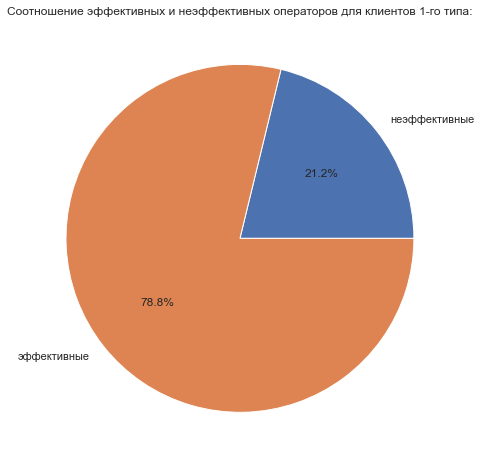

In [42]:
results_type_1 = incoming_calls.pivot_table(index='eff', values='operator_id', aggfunc='count').reset_index()
results_type_1.columns = ['eff', 'count']
results_type_1['share'] = results_type_1['count'] / results_type_1['count'].sum() 
results_type_1 = results_type_1.replace({0:'неэффективные', 1:'эффективные'})
display(results_type_1.style.format({'share': '{:,.1%}'.format}))

sns.set(rc={'figure.figsize':(8, 8)})
plt.pie(results_type_1['share'], labels = results_type_1['eff'], autopct='%.1f%%')
plt.title('Соотношение эффективных и неэффективных операторов для клиентов 1-го типа:');
plt.show()

**Вывод:** для клиентов 1-го типа доля неэфективных операторов составляет 21.2% (106 операторов).

* Клиенты 2-го типа: если среднее количество исходящих звонков в день ниже норматива, оператор неэффективен.

In [43]:
outgoing_calls['cdc'] = outgoing_calls['total_calls'] / outgoing_calls['total_days'] 

# функция возвращает значение 1, если оператор эффективен, и 0 - если нет
def efficiency_type_2(df):
    if df.cdc >= cdc_norm:
        return 1
    else:
        return 0
    
outgoing_calls['eff'] = outgoing_calls.apply(efficiency_type_2, axis=1)
display(outgoing_calls.sort_values(by='eff').head(5))

,user_id,operator_id,total_calls,total_days,total_calls_duration,cdc,eff
0,166407,888532,2,2,25,1.0,0
130,167445,921062,3,2,48,1.5,0
131,167445,935956,1,1,187,1.0,0
133,167451,914168,10,4,1047,2.5,0
134,167451,914170,4,2,373,2.0,0


,eff,count,share
0,неэффективные,153,67.1%
1,эффективные,75,32.9%


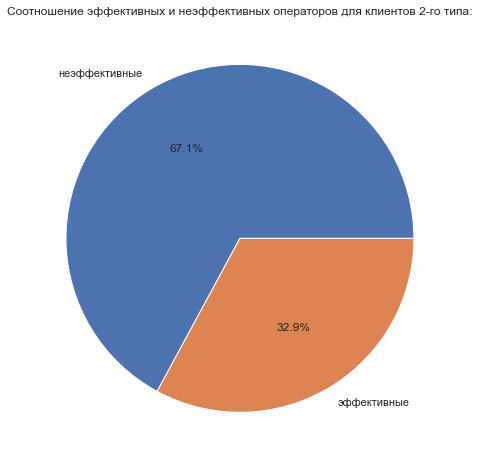

In [44]:
results_type_2 = outgoing_calls.pivot_table(index='eff', values='operator_id', aggfunc='count').reset_index()
results_type_2.columns = ['eff', 'count']
results_type_2['share'] = results_type_2['count'] / results_type_2['count'].sum() 
results_type_2 = results_type_2.replace({0:'неэффективные', 1:'эффективные'})
display(results_type_2.style.format({'share': '{:,.1%}'.format}))

sns.set(rc={'figure.figsize':(8, 8)})
plt.pie(results_type_2['share'], labels = results_type_2['eff'], autopct='%.1f%%')
plt.title('Соотношение эффективных и неэффективных операторов для клиентов 2-го типа:');
plt.show()

**Вывод:** у клиентов 2-го типа доля неэфективных операторов составляет 67.1% (153 операторов).

## Решение основных вопросов заказчика

### Количество клиентов, у которых есть неэффективные операторы

Найдем количество клиентов каждого типа с неэффективными операторами

In [45]:
print("Количество клиентов 1-го типа с неэффективными операторами:", incoming_calls.query('eff==0')['user_id'].nunique())
print("Количество клиентов 2-го типа с неэффективными операторами:", outgoing_calls.query('eff==0')['user_id'].nunique())

Количество клиентов 1-го типа с неэффективными операторами: 76
Количество клиентов 2-го типа с неэффективными операторами: 75


### ТОП-5 компаний с самым боьшим количеством неэффективных операторов

Найдем для каждого типа клиентов ТОП-5 компаний с самым большим количеством неэффективных операторов и определии их долю от общего количества операторов в компании:

,user_id,operators,efficient_operators,non_efficient_operators,share
66,167497,27,21,6,0.222222
103,168187,42,37,5,0.119048
1,166405,11,7,4,0.363636
23,166782,6,3,3,0.500000
17,166688,3,1,2,0.666667


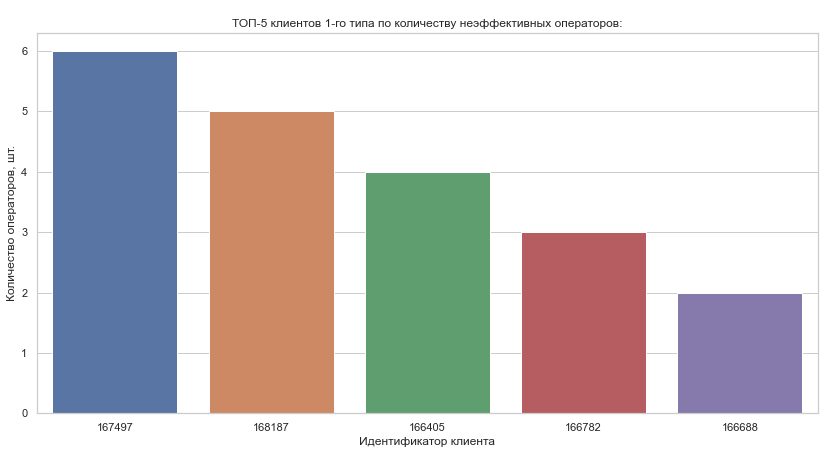

In [46]:
results_type_1 = incoming_calls.pivot_table(index=['user_id'], values=['eff'], aggfunc=['count', 'sum']).reset_index()
results_type_1.columns = ['user_id', 'operators', 'efficient_operators']
results_type_1['non_efficient_operators'] = results_type_1['operators'] - results_type_1['efficient_operators']
results_type_1['share'] = results_type_1['non_efficient_operators'] / results_type_1['operators']
results_type_1 = results_type_1.sort_values(by='non_efficient_operators', ascending=False)
display(results_type_1.head(5))

sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style('whitegrid')
sns.barplot(x='user_id', y='non_efficient_operators', data=results_type_1.head(5), order=results_type_1.head(5).sort_values(by='non_efficient_operators', ascending=False).user_id)
plt.ylabel('Количество операторов, шт.')
plt.xlabel('Идентификатор клиента')
plt.title("\nТОП-5 клиентов 1-го типа по количеству неэффективных операторов:")
plt.show();

,user_id,operators,efficient_operators,non_efficient_operators,share
16,166916,14,3,11,0.785714
0,166407,7,1,6,0.857143
50,167521,8,2,6,0.750000
47,167445,11,6,5,0.454545
44,167359,8,4,4,0.500000


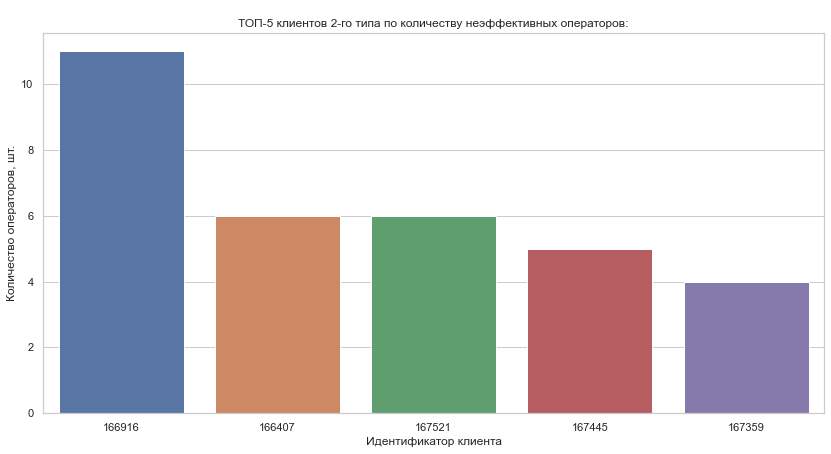

In [47]:
results_type_2 = outgoing_calls.pivot_table(index=['user_id'], values=['eff'], aggfunc=['count', 'sum']).reset_index()
results_type_2.columns = ['user_id', 'operators', 'efficient_operators']
results_type_2['non_efficient_operators'] = results_type_2['operators'] - results_type_2['efficient_operators']
results_type_2['share'] = results_type_2['non_efficient_operators'] / results_type_2['operators']
results_type_2 = results_type_2.sort_values(by='non_efficient_operators', ascending=False)
display(results_type_2.head(5))

sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style('whitegrid')
sns.barplot(x='user_id', y='non_efficient_operators', data=results_type_2.head(5), order=results_type_2.head(5).sort_values(by='non_efficient_operators', ascending=False).user_id)
plt.ylabel('Количество операторов, шт.')
plt.xlabel('Идентификатор клиента')
plt.title("\nТОП-5 клиентов 2-го типа по количеству неэффективных операторов:")
plt.show();

## Проверка статистических гипотез

Мы хотим проверим следующие гипотезы:
* Доля неэффективных операторов у клиентов 1-го и 2-го типа различается;
* Среднее время ожидания у клиентов на тарифном плане В выше, чем у клиентов на тарифном плане А;

### Двухсторонняя проверка: доля неэффективных операторов у клиентов 1-го и 2-го типа различается

Проверим, находят ли статистические критерии разницу между долями неэффективных операторов у клиентов 1-го и 2-го типа.

Введем нулевую и алтернативную гипотезы:

$$
\left\{
    \begin{array}\\
        H_{0}: {Доля \ неэффективных \ операторов \ у \ клиентов \ 1-го \ и \ 2-го \ типа \ одинакоаы.}\\
        H_{1}: {Между \ долями \ неэффективных \ операторов \ у \ клиентов \ 1-го \ и \ 2-го \ типа \ есть \ значимая \ разница.}
    \end{array}
\right.
$$

Критический уровень статистической значимости: alpha = 0.05

Рассчитаем статистическую значимость различий между выборками:

In [49]:
# функция, реализующая z-тест для набора данных
def z_test (a_trials, b_trials, a_succeses, b_succeses, alpha):

    successes = np.array([a_succeses, b_succeses])
    trials = np.array([a_trials, b_trials])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: {0:.3f}'.format(p_value))
    return p_value

alpha = 0.05 # критический уровень статистической значимости

total_operators_type_1 = results_type_1.operators.sum()
non_efficient_operators_type_1 = results_type_1.non_efficient_operators.sum()
total_operators_type_2 = results_type_2.operators.sum()
non_efficient_operators_type_2 = results_type_2.non_efficient_operators.sum()

# определим статистическую значимость различий между выборками
p_value = z_test(total_operators_type_1, total_operators_type_2, non_efficient_operators_type_1, non_efficient_operators_type_2, alpha)

# относительное различие в конверсии между группами
print('Относительное различие между выборками: {0:.5f}'.format((non_efficient_operators_type_2 / total_operators_type_2)/(non_efficient_operators_type_1 / total_operators_type_1)-1)) 

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет оснований считать выборки разными'
    )

p-value: 0.000
Относительное различие между выборками: 2.16441
Отвергаем нулевую гипотезу: между выборками есть значимая разница


**Вывод:** p-value = 0. Значит нулевую гипотезу о том, что доля неэффективных операторов у клиентов 1-го и 2-го типа одинакова, отвергаем.

### Проверка нормальности распределения среднего времени ожидания

Для удобства объединим датасет waiting_time с нужными столбцами датасета clients и разделим его на клиентов с тарифом А и B:

In [50]:
total_waiting_time = total_waiting_time.merge(clients.query('user_id in @unique_user_id')[['user_id','tariff_plan']], on=["user_id"])
tariff_A = total_waiting_time.query('tariff_plan=="A"')
tariff_B = total_waiting_time.query('tariff_plan=="B"')
display(tariff_A.head(5))
display(tariff_B.head(5))

,user_id,operator_id,mean_wt,tariff_plan
49,166609,-1,13.170000,A
50,166609,886146,9.000000,A
51,166609,892798,43.000000,A
96,166725,-1,11.602984,A
97,166725,889754,8.163595,A


,user_id,operator_id,mean_wt,tariff_plan
0,166377,-1,18.212798,B
1,166377,880020,7.714286,B
2,166377,880022,14.000000,B
3,166377,880026,5.935185,B
4,166377,880028,6.106504,B


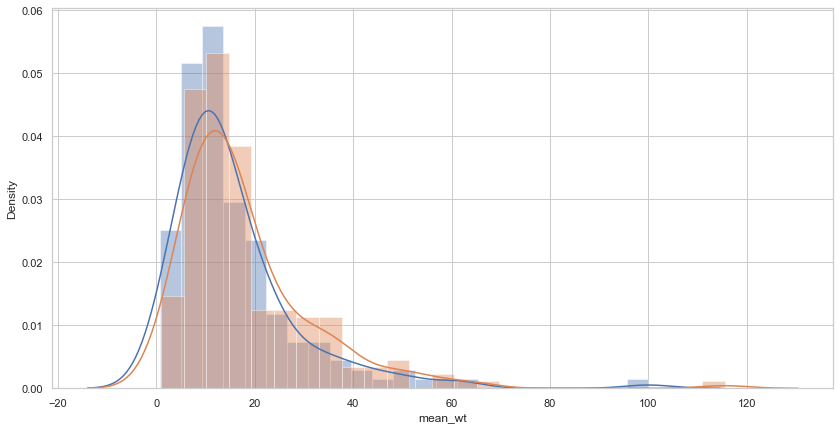

In [51]:
sns.distplot(tariff_A['mean_wt'], label='A')
sns.distplot(tariff_B['mean_wt'], label='B');

**Проверка распределения при помощи QQ-графиков**

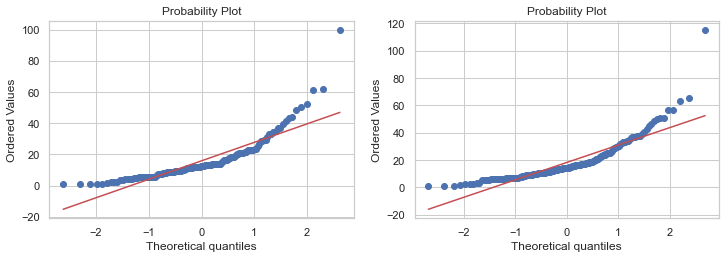

In [52]:
plt.figure(figsize =(12,8))
plt.subplot(2,2,1)
st.probplot(tariff_A['mean_wt'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(tariff_B['mean_wt'], dist="norm", plot=plt)
plt.show()

В соответствии с графиками делаем вывод, что среднее время ожидания у клиентов распределено не нормально.

**Проверка при помощи критерия Шапиро-Уилка:**

Критерий Шапиро-Уилка:

$$
\left\{
    \begin{array}\\
        H_{0}: {Среднее \ время \ ожидания \ распределено \ нормально.}\\
        H_{1}: {Среднее \ время \ ожидания \ распределено \ не \ нормально.}
    \end{array}
\right.
$$

In [53]:
print("W-statistic: %f, p-value: %f" % st.shapiro(tariff_A['mean_wt']))
print("W-statistic: %f, p-value: %f" % st.shapiro(tariff_B['mean_wt']))

W-statistic: 0.772562, p-value: 0.000000
W-statistic: 0.792653, p-value: 0.000000


Отвергаем нулевую гипотезу: распределения не являются нормальными

### Односторонняя проверка: среднее время ожидания у клиентов на тарифном плане В выше, чем у клиентов на тарифном плане А

Введем нулевую и альтернативную гипотезы:

$$
\left\{
    \begin{array}\\
        H_{0}: {Среднее \ время \ ожидания \ у \ клиентов \ на \ тарифном \ плане \ А \ и \ В \ одинаково.}\\
        H_{1}: {Среднее \ время \ ожидания \ у \ клиентов \ на \ тарифном \ плане \ В \ выше, \ чем \ у \ клиентов \ на\ тарифном \ плане \ А.}
    \end{array}
\right.
$$

Уровень значимости: α = 0.05

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух независимых выборок.

Если p-value будет меньше α, то нулевую гипотезу о равенстве среднего времени ожидания у клиентов отвергаем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.


In [54]:
alpha = 0.05

results = st.ttest_ind(tariff_B['mean_wt'], tariff_A['mean_wt'], equal_var=False)
print("p-значение:", results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (tariff_B['mean_wt'].mean() > tariff_A['mean_wt'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.05967937595651875
Не получилось отвергнуть нулевую гипотезу


**Вывод:** p-value получилось больше выбранного уровня α = 0.05. Поэтому данные не позволили нам отвергнуть нулевую гипотезу: среднее время ожидания у клиентов на тарифном плане А и тарифном плане В значимо не отличается. 

## Общий вывод и рекомендации для заказчика

Чтобы помочь телеком-провайдеру определить неэффективных операторов мы использовали входные данные со статистикой использования услуг и описанием клиентов.

Данные были проверены на наличие ошибок и оценки их влияния на исследование; была выполнена предобработка данных, которая в себя включала поиск пропущенных значений, приведение типов, обработку дубликатов, обработку ошибок и аномалий.

После этого была выполнена классификация клиентов и провелен исследовательский анализ данных и получены следующие результаты:
1. У провайдера 129 клиентов 1-го типа (Call-центры, которые распределяют входящие вызовы по своим операторам) и 179 клиентов 2-го типа (Call-центры, которые обеспечивают исходящие вызовы от своих операторов);
2. ТОП-5 клиентов по количество операторов:
    * Идентификаторы клиентов 1-го типа: 168187, 167626, 167497, 168252, 168361;
    * Идентификаторы клиентов 2-го типа: 166916, 167176, 167521, 167445, 168073;

3. Пороги показателей эффективности для клиентов 1-го типа:
    * Доля пропущенных звонков, которую не следует превышать рассчитана индивидуально для каждого клиента (см.п.5.1);
    * Среднее время ожидания ответа: 12.0 мин.
4. Пороги показателей эффективности для клиентов 2-го типа:
    * Среднее время обработки исходящего вызова (с учетом периода бездействия): 94.5 мин;
    * Норматив по количеству звонков: 4 звонка в день;
5. Количество клиентов с неэффективными операторами:
    * 1-ый тип: 76 операторов;
    * 2-ой тип: 75 операторов;
5. Доля неэффективных операторов:
    * Для клиентов 1-го типа: 21.2% (106 операторов);
    * Для клиентов 2-го типа: 67.1% (153 оператора).;
6. ТОП-5 клиентов с самым большим количеством неэффективных операторов: 
    * Идентификаторы клиентов 1-го типа: 167497, 168187, 166405, 166782, 166688;
    * Идентификаторы клиентов 2-го типа: 166916, 166407, 167521, 167445, 167359;
    
7. Проверка гипотез:    
    * На имеющихся данных, на уровне значимости 5%, есть основания отвергнуть нулевую гипотезу: доля неэффективных операторов у клиентов 1-го и 2-го типа различается;
    * На имеющихся данных, на уровне значимости 5%, есть основания не отвергать нулевую гипотезу: среднее время ожидания у клиентов на тарифном плане А и тарифном плане В не отличается;
    
**Рекомендации для заказчика:**

Ожидается, что планируемый функционал для определения неэффективных операторов будет востребован у клиентов телеком-провайдера, в первую очередь у CALL-центров, которые обеспечивают исходящие вызовы от своих операторов. Рекомендуется, чтобы инструмент предоставлял возможность регулярного выявления неэффективных операторов для оперативного контроля и повышения эффективности работы CALL-центра. Выявление неэффективных сотрудников позволит в дальнейшем увеличить ценность сервиса телеком-провайдера, а значит потенциально увеличит время жизни клиента. 

## Материалы по итогу исследования:
1. [Презентация](https://drive.google.com/file/d/1wMBczzNtWElz3BugKOmJBH7uL_ODaIcM/view?usp=sharing)
2. [Дашборд](https://public.tableau.com/app/profile/igor6948/viz/Final_dash_16650008119210/Dashboard1?publish=yes)